In [162]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import scipy
import matplotlib.pylab as plt
import matplotlib.animation as animation
import seaborn as sns
import ast
import glob
import tempfile
import os
import time
import multiprocessing as mp


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

np.random.seed(0)

In [8]:
IMAGE_LOC = '../HMPDataset/'
activity_list = [i for i in glob.glob(f'{IMAGE_LOC}/*') if i.find('_') > 0 and "MODEL" not in i]

In [9]:
def read_data(activity_list):
    '''Read files in each activity in activity_list
    Returns dict: key = activity name -> array of numpy arrays of shape (n_observations, 3) = (ax,ay,az)
    '''
    data = {}
    
    for t in activity_list: #loop over each activity type
        activity_name = t.split('/')[-1]
        data[activity_name] = []
    
        filenames = glob.glob(t + '/*')
        
        for f in filenames: #loop over every participants time-series
            df = pd.read_csv(f, sep=' ', header=None)
            
            #ts = np.sqrt((df**2).sum(axis=1)) #magnitude of acceleration vector
            
            data[activity_name].append(np.array(df))
    
    return data

def get_acceleration_timeseries(data):
    '''Input: data returned by read_data
    Output: dictionary mapping activity name -> list of single time-series of acceleration magnitudes
    '''
    
    data_ts = {}
    
    for k in data:
        data_ts[k] = []
        
        for sample in data[k]: #(ax, ay, az)
            data_ts[k].append(np.sqrt((sample**2).sum(axis=1)))
    
    return data_ts

In [10]:
data = read_data(activity_list)
data_ts = get_acceleration_timeseries(data)

In [11]:
def featurize_stats(params):
    ts = params[0]
    label = params[1]
    bins = params[2]
    #basic statistical measures
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b,p = plt.hist(ts, bins=bins)
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    if median == 0: 
        features = {'mean_over_median': 0, #dimensionless            
                    'std_over_median': 0, #dimensionless            
                    'length': length,
                    'kurtosis': kurtosis, #already dimensionless by definition
                   }
        
    else: 
        features = {'mean_over_median': mean/median, #dimensionless            
            'std_over_median': std/median, #dimensionless            
            'length': length,
            'kurtosis': kurtosis, #already dimensionless by definition
           }
        
    for i, val in enumerate(n):
        features[f'binfrac_{i}'] = val
    
    features['label'] = label
    
    return features

In [12]:
bins = np.arange(0,100,10)
data_params = []
for k in data_ts:
    for elem in data_ts[k]:
        data_params.append((elem,k,bins))

In [13]:
then = time.time()
pool = mp.Pool(processes=8)
results = pool.map(featurize_stats,data_params)
print((time.time()-then)/60, "minutes")


0.035092282295227054 minutes


Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-7:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-1:
  File "/home/mcliffor/anaconda3/envs/tf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mcliffor/anaconda3/envs/tf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mcliffor/anaconda3/envs/tf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mcliffor/anaconda3/envs/tf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-2:
  File "/home/mcliffor/anaconda3/envs/tf/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._a

In [14]:
results = pd.DataFrame(results) 
train_df, test_df = train_test_split(results, train_size=0.75)

/home/mcliffor/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [71]:
one_hot = np.array(train_df['label'])
label_encoder = LabelEncoder()
integer_encoder = label_encoder.fit_transform(one_hot)
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoder = integer_encoder.reshape(len(integer_encoder),1)
train_label = one_hot_encoder.fit_transform(integer_encoder)

one_hot = np.array(test_df['label'])
#label_encoder = LabelEncoder()
integer_encoder = label_encoder.transform(one_hot)
#one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoder = integer_encoder.reshape(len(integer_encoder),1)
test_label = one_hot_encoder.transform(integer_encoder)

In [112]:
model = keras.Sequential([
    keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(13,)),
    keras.layers.Dense(14, activation=tf.nn.log_softmax)
]) 

In [113]:
from tensorflow.keras.callbacks import LambdaCallback

In [114]:
h  = []
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: h.append(model.layers[0].get_weights()))

In [115]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)

In [116]:
model.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])

In [117]:
history = model.fit( train_df.drop('label', axis=1), train_label, epochs=80, batch_size=100, verbose=0, callbacks=[print_weights])

In [161]:
len(h)

80

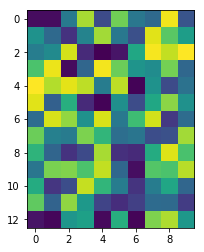

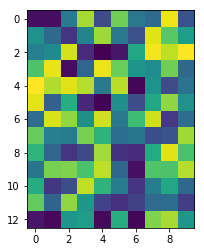

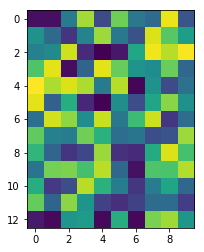

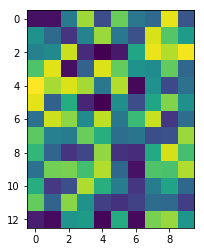

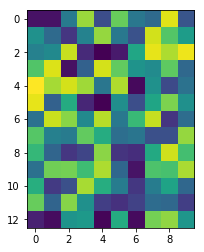

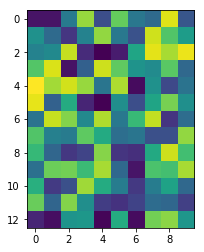

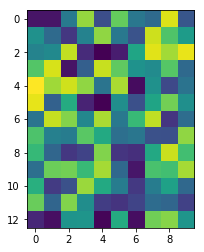

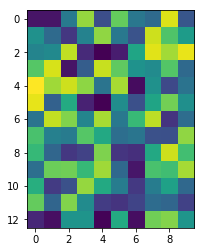

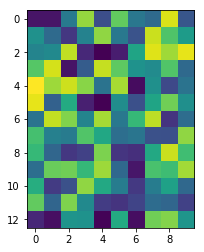

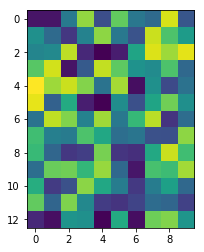

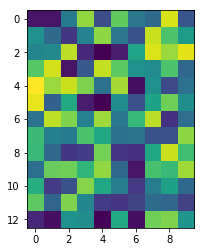

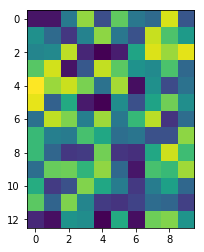

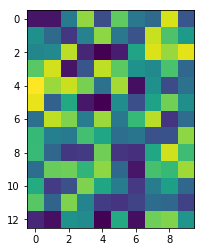

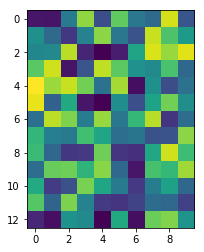

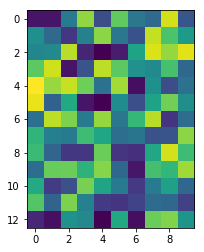

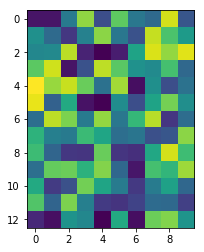

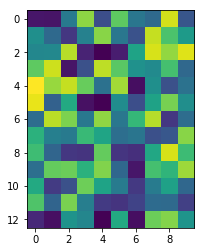

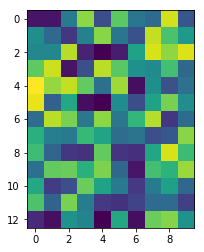

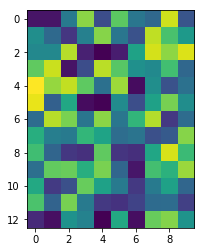

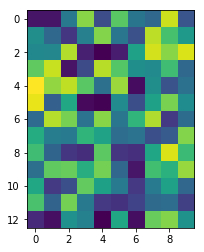

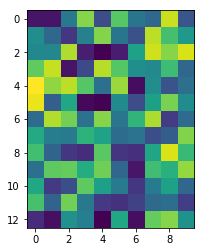

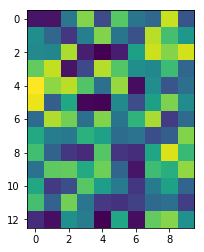

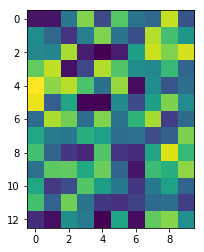

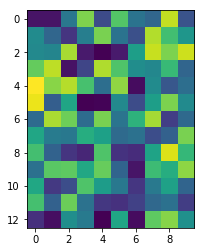

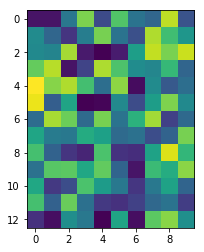

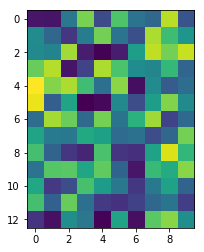

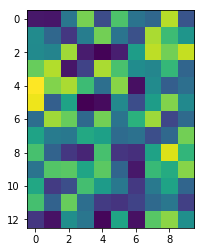

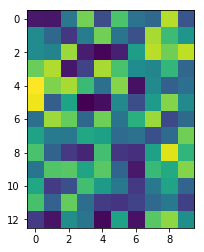

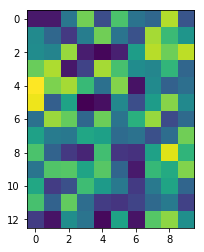

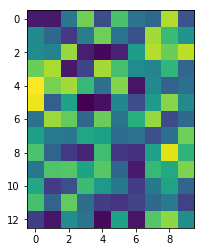

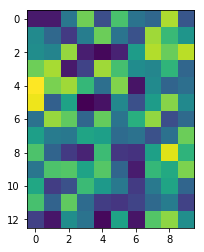

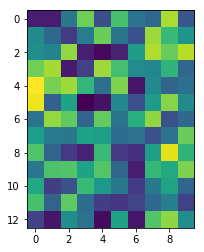

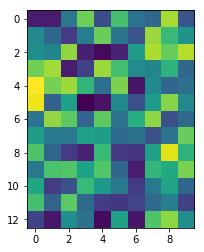

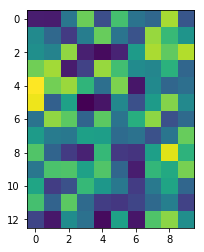

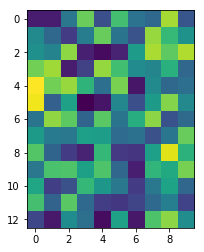

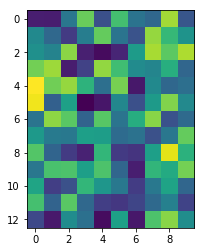

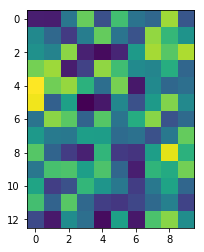

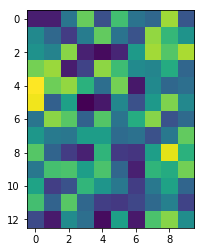

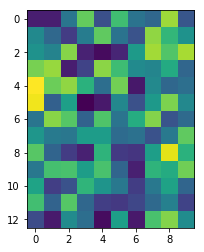

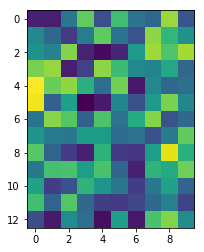

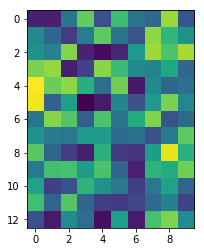

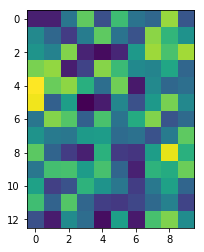

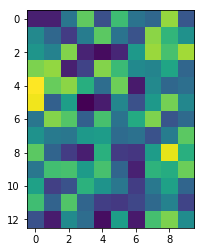

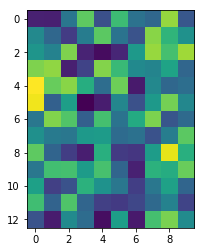

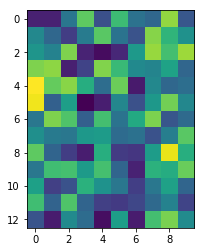

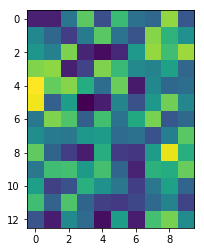

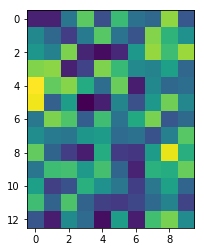

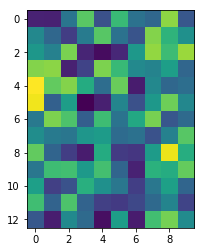

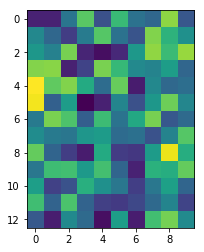

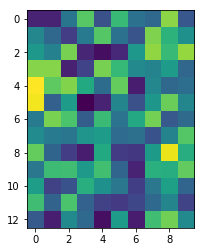

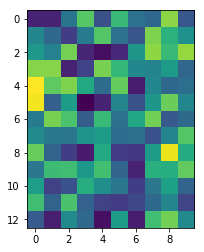

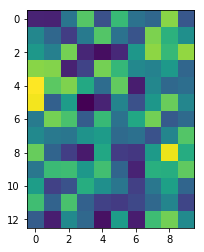

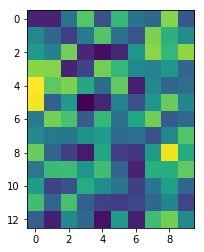

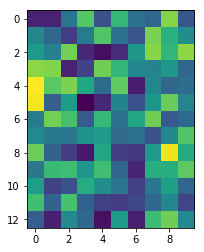

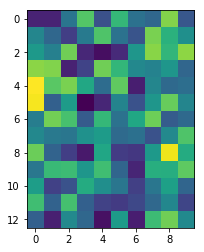

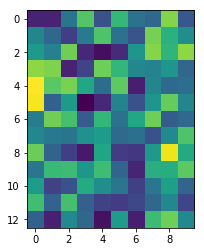

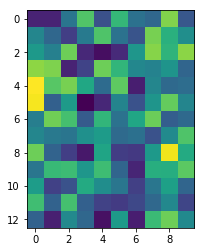

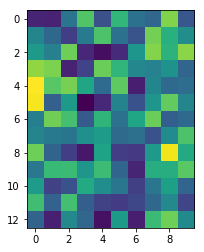

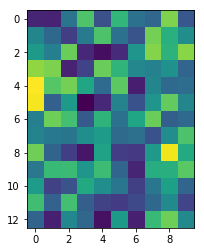

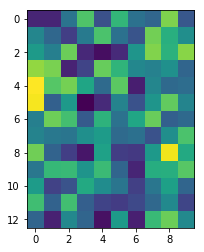

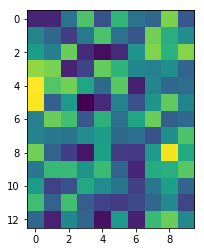

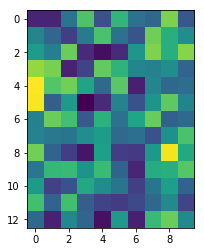

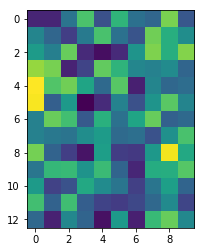

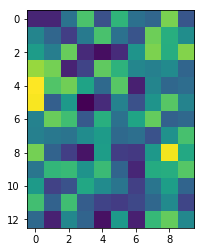

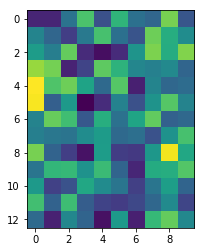

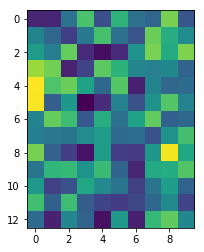

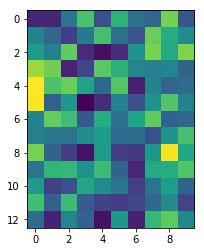

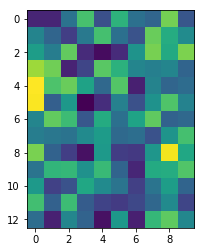

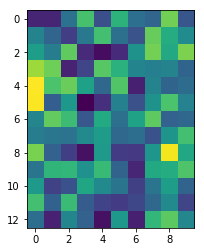

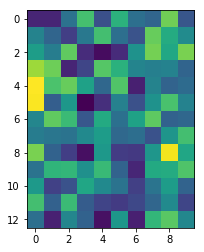

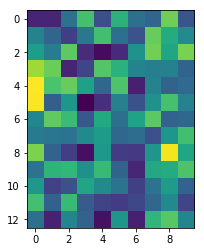

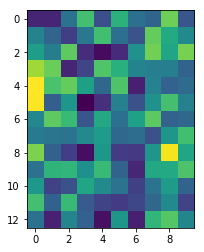

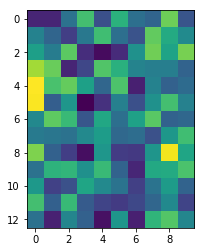

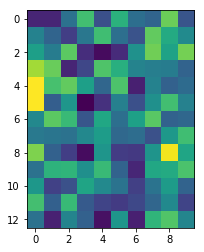

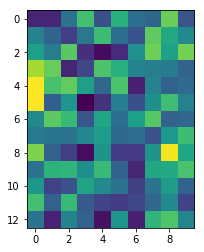

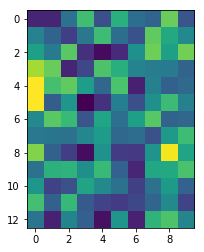

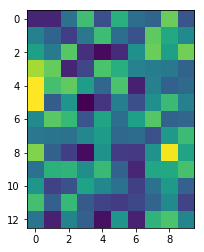

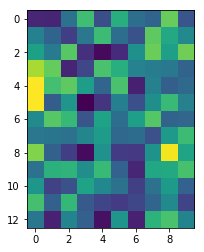

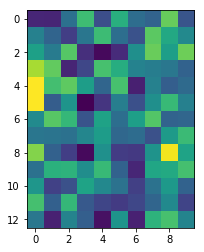

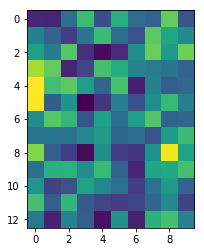

In [163]:
for i in range(len(h)):
    plt.imshow(h[i][0])
    plt.show()

In [ ]:
b[0]

In [180]:
b = [ [h[i][0] for i in range(len(h))  ]
write_gif(b, 'out.gif', fps=5,)


SyntaxError: invalid syntax (<ipython-input-180-bcc33a8e6e12>, line 2)

In [170]:
j[1]

In [166]:
from PIL import Image
from matplotlib import cm
j = [Image.fromarray(np.uint8(cm.gist_earth(h[i][0]))) for i in range(len(h))]

j[0].save("out.gif",save_all=True, append_image=j[1:], duration=100)



In [158]:
j

[<PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EA0F0>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EA048>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EA1D0>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EA358>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EA278>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EA550>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EA518>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EA3C8>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EA438>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EA748>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EAA58>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EA5F8>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EA780>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EAE80>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EA908>,
 <PIL.Image.Image image mode=L size=10x13 at 0x7FC72B8EA8D0>,
 <PIL.Im

<IPython.core.display.Javascript object>


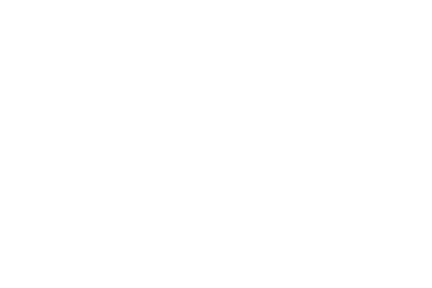

<IPython.core.display.Javascript object>


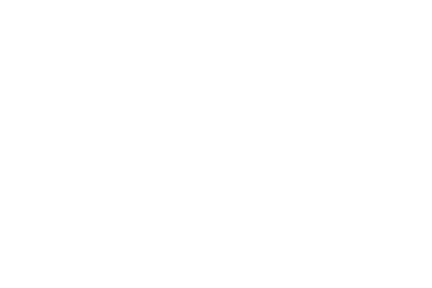

<IPython.core.display.Javascript object>


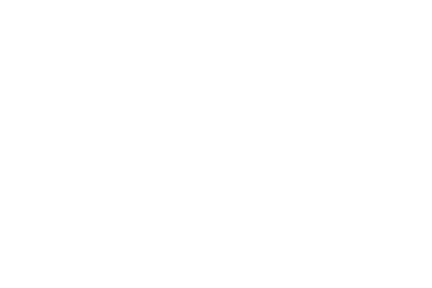

<IPython.core.display.Javascript object>


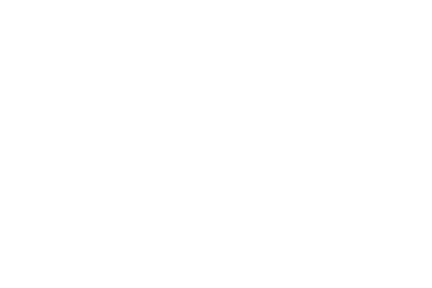

Traceback (most recent call last):
  File "/home/mcliffor/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/mcliffor/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [149]:
j = [[plt.imshow(h[i][0],animated=True)] for i in range(len(h))]

fig = plt.figure()
ani = animation.ArtistAnimation(fig,j, interval=50,blit=True, repeat_delay = 1000)
ani.save("tep.gif", writer='imagemagick', fps=1)
plt.show()


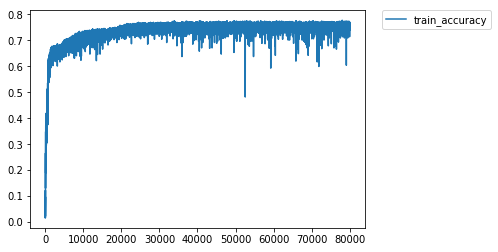

In [20]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [21]:
test_loss, test_acc = model.evaluate(test_df.drop('label', axis=1), test_label)

print('Test accuracy:', test_acc)

210/210 [==============================] - 0s 167us/step
Test accuracy: 0.7095238078208197


In [22]:
# Added code snippet from https://www.tensorflow.org/serving/tutorials/Serving_REST_simple
# to save model for TF-serving

save = False

if save == True:
    MODEL_DIR = "models/"
    version = 1
    export_path = os.path.join(MODEL_DIR, str(version))
    print('export_path = {}\n'.format(export_path))
    if os.path.isdir(export_path):
        print('\nAlready saved a model, cleaning up\n')
        !rm -r {export_path}

    tf.saved_model.simple_save(
        keras.backend.get_session(),
        export_path,
        inputs={'input_data': model.input},
        outputs={t.name:t for t in model.outputs})

    print('\nSaved model:')
    !ls -l {export_path}

In [67]:
import random

sample_size = 200
sorted_sample = [
    x[i] for i in sorted(random.sample(range(len(x)), sample_size))
]

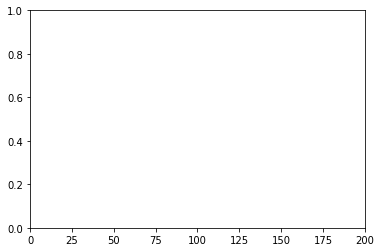

In [70]:
x = history.history['acc']
x = sorted_sample
t = np.linspace(1,len(x),len(x))

fig, ax = plt.subplots()
ax.axis([0,len(x),0,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(x), interval = 20)

from IPython.display import HTML
HTML(ani.to_jshtml())